In [1]:
import warnings
warnings.filterwarnings("ignore")

#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import math

#Visualizing
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:.2f}'.format

#Acquire
from env import host, user, password 
import os
import acquire

#Prepare
import prepare

#SKLearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE


#Exploring
import explore

#Evaluate
import evaluate

In [2]:
df = acquire.get_zillow_data(cached=False)
df.head()

,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,bathroomcnt,...,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc
0,nan,nan,2.00,nan,nan,nan,10711855,1087254,nan,2.00,...,nan,60371132321007.00,-0.01,2017-07-07,None,None,None,Central,None,None
1,nan,nan,2.00,nan,nan,1.00,10711877,1072280,nan,2.00,...,nan,60371132321007.00,0.02,2017-08-29,Central,None,None,Central,None,None
2,nan,nan,2.00,nan,nan,1.00,10711888,1340933,nan,2.00,...,nan,60371132321007.00,0.08,2017-04-04,Central,None,None,Central,None,None
3,nan,nan,2.00,nan,nan,nan,10711910,1878109,nan,2.00,...,nan,60371132321008.00,-0.04,2017-03-17,None,None,None,Central,None,None
4,nan,nan,2.00,nan,nan,nan,10711923,2190858,nan,2.00,...,nan,60371132321008.00,-0.01,2017-03-24,None,None,None,Central,None,None


In [3]:
#Prepare the data using wrangle zillow 2
df = prepare.wrangle_zillow_2nd()
df.shape

(69305, 21)

In [4]:
#Create LA County Dataframe
df_la = df[df.LA == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 
df_la.shape

(43768, 18)

In [5]:
#Create Ventura County df
df_vent = df[df.Ventura == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 
df_vent.shape

(5695, 18)

In [6]:
#Create Orange County df
df_orange = df[df.Orange == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 
df_orange.shape

(19842, 18)

# Feature Engineering: SelectKBest by County

## Los Angeles 
 - scaled_bathroomcnt
 - scaled_bedroomcnt
 - scaled_calculatedfinishedsquarefeet
 - scaled_regionidzip
 - scaled_taxrate

In [7]:
partitions = explore.split(df_la, target_var='logerror')
train = partitions[0]
partitions[0] = train

In [8]:
# the variables that need scaling
scaled_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'age', 'taxrate', 'acres']
# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]
# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]
# fit the minmaxscaler to X_train
X_train = X[0]
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])
def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)
for i in range(len(X)):
    X[i] = scale_and_concat(X[i])

In [9]:
X_validate = partitions[2]
X_test = partitions[3]
y_train = partitions[4]
y_validate = partitions[5] 
y_test = partitions[6]

In [10]:
X_train_scaled = X[0][['cola', 'hot_month_sale', 'has_heat', 'scaled_bathroomcnt',
       'scaled_bedroomcnt', 'scaled_buildingqualitytypeid',
       'scaled_calculatedfinishedsquarefeet', 'scaled_latitude',
       'scaled_longitude', 'scaled_rawcensustractandblock',
       'scaled_regionidcity', 'scaled_regionidzip',
       'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt',
       'scaled_age', 'scaled_taxrate', 'scaled_acres']]

In [11]:
X_train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,latitude,longitude,rawcensustractandblock,regionidcity,regionidzip,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,age,taxrate,acres,cola,hot_month_sale,has_heat
parcelid,,,,,,,,,,,,,,,,,
12248933,2.00,4.00,8.00,1784.00,33.88,-118.30,60376031.02,45398.00,96104.00,59212.00,46364.00,48.00,1.40,0.12,0,0,1
11110824,1.00,2.00,6.00,834.00,34.45,-118.50,60379200.20,54311.00,96373.00,60400.00,133300.00,40.00,1.48,3.40,0,0,1
11115676,3.00,3.00,8.00,1320.00,34.44,-118.56,60379201.14,54311.00,96377.00,206386.00,118289.00,13.00,1.48,0.61,0,0,1
11059395,2.00,4.00,8.00,1916.00,34.26,-118.50,60371114.00,12447.00,96369.00,110195.00,59100.00,58.00,1.29,0.17,1,0,1
12363460,2.00,2.00,8.00,1817.00,33.98,-118.21,60375332.03,39076.00,96110.00,105808.00,114896.00,70.00,1.56,0.13,0,1,1


In [12]:
f_selector = SelectKBest(f_regression, k=5)

In [13]:
# we are running the scaled train data through kbest
f_selector = f_selector.fit(X_train_scaled, y_train)

In [14]:
# Transforming the data
X_train_reduced = f_selector.transform(X_train_scaled)
print(X_train.shape)
print(X_train_reduced.shape)

(24509, 17)
(24509, 5)


In [15]:
f_support = f_selector.get_support()
f_support

array([False, False, False,  True,  True, False,  True, False, False,
       False, False,  True, False, False, False,  True, False])

In [16]:
# Listing out the features so we can see which ones were returned
f_feature = X_train_scaled.iloc[:, f_support].columns.tolist()
f_feature

['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']

In [17]:
# Returning a scaled dataframe with only our best features
# X_reduced_scaled = X_train_scaled.iloc[:, f_support]
# X_reduced_scaled.head()

,scaled_bathroomcnt,scaled_bedroomcnt,scaled_calculatedfinishedsquarefeet,scaled_regionidzip,scaled_taxrate
12248933,0.12,0.38,0.15,0.80,0.24
11110824,0.00,0.12,0.05,0.85,0.25
11115676,0.25,0.25,0.10,0.85,0.25
11059395,0.12,0.38,0.16,0.85,0.22
12363460,0.12,0.12,0.15,0.81,0.27


### Baseline Model

In [18]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
X_test = pd.DataFrame(X_test)

# 1. Predict logerror_pred_mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean
y_test['logerror_pred_mean'] = logerror_pred_mean

# 2. compute logerror_pred_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median
y_test['logerror_pred_median'] = logerror_pred_median

In [19]:
#Evaluate the baseline model using the mean
evaluate.baseline_mean_errors(y_train.logerror)

{'sse': 607.3551778444731,
 'mse': 0.02478090406970799,
 'rmse': 0.15741951616527092}

In [20]:
#Evaluate the baseline model using the median
evaluate.baseline_median_errors(y_train.logerror)

{'sse': 609.1125597961818,
 'mse': 0.02485260760521367,
 'rmse': 0.15764709830889267}

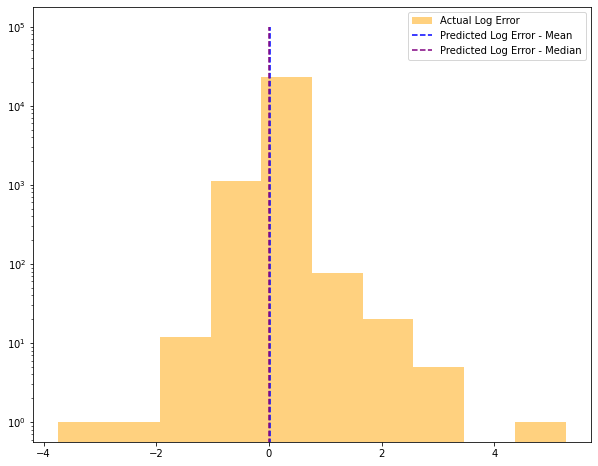

In [21]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(10, 8))
plt.hist(y_train.logerror, color='orange', alpha=.5, label="Actual Log Error", log=True)
plt.vlines(y_train.logerror.mean(), 0, 10**5,  ls='--', color='blue', label="Predicted Log Error - Mean")
plt.vlines(y_train.logerror.median(), 0, 10**5,  ls='--', color='purple', label="Predicted Log Error - Median")
plt.legend()
plt.show()

In [22]:
#Now that I have established the mean as the baseline, I will drop the median and rename baseline to yhat_baseline
y_train.drop(columns={'logerror_pred_median'}, inplace=True)
y_validate.drop(columns={'logerror_pred_median'}, inplace=True)
y_test.drop(columns={'logerror_pred_median'}, inplace=True)
y_train.head()

,logerror,logerror_pred_mean
parcelid,,
12248933,-0.05,0.02
11110824,0.41,0.02
11115676,-0.06,0.02
11059395,0.01,0.02
12363460,-0.15,0.02


In [23]:
y_train.rename(columns={'logerror_pred_mean': 'yhat_baseline'}, inplace=True)
y_validate.rename(columns={'logerror_pred_mean': 'yhat_baseline'}, inplace=True)
y_test.rename(columns={'logerror_pred_mean': 'yhat_baseline'}, inplace=True)
y_train.head()

,logerror,yhat_baseline
parcelid,,
12248933,-0.05,0.02
11110824,0.41,0.02
11115676,-0.06,0.02
11059395,0.01,0.02
12363460,-0.15,0.02


### LinearRegression (OLS) Model

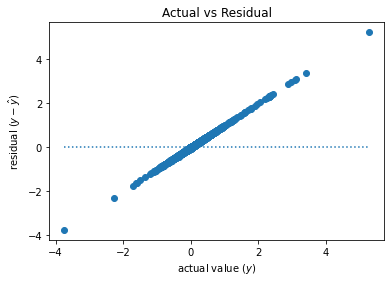

sse    605.89
ess      1.47
tss    607.36
mse      0.02
rmse     0.16
r^2      0.00
dtype: float64

In [24]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']], y_train.logerror)

# predict train
y_train['yhat_lm'] = lm.predict(X_train_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']])

# compute residuals
y_train['residual'] = y_train['yhat_lm'] - y_train['logerror']
y_train['baseline_residual'] = y_train['yhat_baseline'] - y_train['logerror']

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.logerror, y_train.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on in-sample data
evaluate.regression_errors(y_train.logerror, y_train.yhat_lm)

### TweedieRegressor (GLM) Model

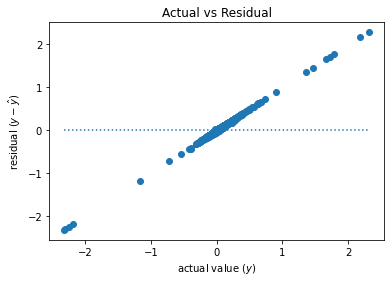

sse    68.62
ess     0.14
tss    68.75
mse     0.02
rmse    0.15
r^2     0.00
dtype: float64

In [47]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']], y_train.logerror)

# predict train
y_train['yhat_glm'] = glm.predict(X_train_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']])

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.logerror, y_train.yhat_glm)

#How does the GLM model perform on in-sample data?
evaluate.regression_errors(y_train.logerror, y_train.yhat_glm)

### LassoLars

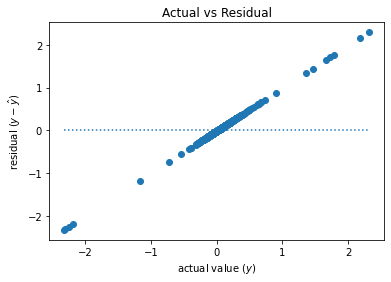

sse    68.75
ess     0.00
tss    68.75
mse     0.02
rmse    0.15
r^2     0.00
dtype: float64

In [48]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']], y_train.logerror)

# predict train
y_train['yhat_lars'] = lars.predict(X_train_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']])

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.logerror, y_train.yhat_lars)

#Retrieve evaluation metrics for Lasso + Lars Model on in-sample data
evaluate.regression_errors(y_train.logerror, y_train.yhat_lars)